In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub


In [3]:
df=pd.read_csv("wine-reviews.csv",usecols= ['country','description','points','price','variety','winery'])

In [4]:
df.tail()

,country,description,points,price,variety,winery
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Pinot Gris,Domaine Marcel Deiss
129970,France,"Big, rich and off-dry, this is powered by inte...",90,21.0,Gewürztraminer,Domaine Schoffit


In [5]:
df=df.dropna(subset=["description","points"])

In [6]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


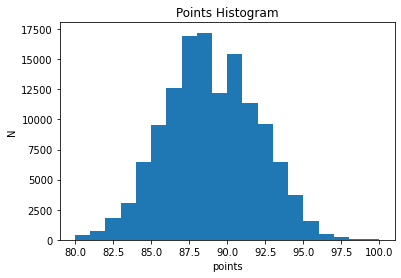

In [7]:
plt.hist(df.points,bins=20)
plt.title("Points Histogram")
plt.ylabel("N")
plt.xlabel("points")
plt.show()

In [8]:
df["label"]=(df.points>=90).astype(int)
df=df[["description","label"]]

In [9]:
df.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [10]:
train,val,test=np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [13]:
embedding= "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer=hub.KerasLayer(embedding,dtype=tf.string,trainable=True)

In [14]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.48883265,  0.01914097,  0.20891008, ...,  0.0193505 ,
        -0.07619956,  0.08126692],
       [ 0.24558277, -0.09888058, -0.12284812, ..., -0.1184976 ,
        -0.09648135,  0.07978416],
       [ 0.4296257 , -0.10493334, -0.02642559, ...,  0.15325795,
        -0.5151422 ,  0.16865036],
       ...,
       [ 0.0190465 , -0.23564431, -0.00247345, ...,  0.10729893,
        -0.12862206,  0.10158342],
       [ 0.45056587, -0.33289796, -0.01531622, ..., -0.00836369,
        -0.17562212, -0.144812  ],
       [ 0.28453758, -0.43914145, -0.04534363, ...,  0.05997062,
        -0.31344137,  0.03676033]], dtype=float32)>

In [24]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )

In [26]:
model.evaluate(train_data)

102/102 [==============================] - 22s 127ms/step - loss: 0.6890 - accuracy: 0.5311


[0.6890345215797424, 0.5310937166213989]

In [27]:
model.evaluate(valid_data)

13/13 [==============================] - 2s 125ms/step - loss: 0.6915 - accuracy: 0.5117


[0.6914793848991394, 0.5116565227508545]

In [28]:
history=model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 134s 1s/step - loss: 0.5590 - accuracy: 0.7067 - val_loss: 0.4112 - val_accuracy: 0.8198
Epoch 2/5
102/102 [==============================] - 126s 1s/step - loss: 0.3780 - accuracy: 0.8414 - val_loss: 0.3782 - val_accuracy: 0.8261
Epoch 3/5
102/102 [==============================] - 121s 1s/step - loss: 0.3209 - accuracy: 0.8711 - val_loss: 0.3902 - val_accuracy: 0.8269
Epoch 4/5
102/102 [==============================] - 128s 1s/step - loss: 0.2978 - accuracy: 0.8825 - val_loss: 0.4060 - val_accuracy: 0.8262
Epoch 5/5
102/102 [==============================] - 133s 1s/step - loss: 0.2834 - accuracy: 0.8876 - val_loss: 0.4087 - val_accuracy: 0.8257


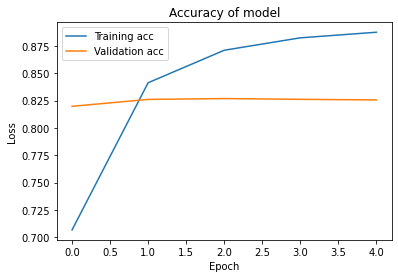

In [29]:
plt.plot(history.history['accuracy'],label="Training acc")
plt.plot(history.history['val_accuracy'],label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

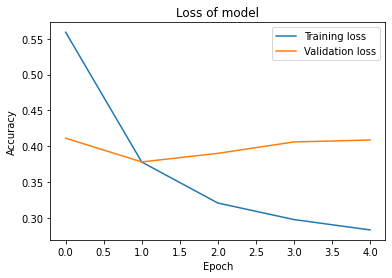

In [30]:
plt.plot(history.history['loss'],label="Training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.title("Loss of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [32]:
encoder= tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [35]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U15')

In [36]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [38]:
model.evaluate(train_data)
model.evaluate(test_data)

13/13 [==============================] - 3s 217ms/step - loss: 0.6936 - accuracy: 0.4162


[0.6936483383178711, 0.4162178933620453]

In [39]:
history=model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 75s 636ms/step - loss: 0.5587 - accuracy: 0.7028 - val_loss: 0.3861 - val_accuracy: 0.8230
Epoch 2/5
102/102 [==============================] - 54s 528ms/step - loss: 0.3686 - accuracy: 0.8345 - val_loss: 0.3476 - val_accuracy: 0.8421
Epoch 3/5
102/102 [==============================] - 54s 530ms/step - loss: 0.3514 - accuracy: 0.8424 - val_loss: 0.3461 - val_accuracy: 0.8406
Epoch 4/5
102/102 [==============================] - 55s 535ms/step - loss: 0.3416 - accuracy: 0.8473 - val_loss: 0.3420 - val_accuracy: 0.8421
Epoch 5/5
102/102 [==============================] - 57s 559ms/step - loss: 0.3378 - accuracy: 0.8482 - val_loss: 0.3474 - val_accuracy: 0.8425


In [40]:
model.evaluate(test_data)

13/13 [==============================] - 3s 231ms/step - loss: 0.3542 - accuracy: 0.8414


[0.3541746139526367, 0.8414371609687805]